In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# ResNet50 による 1000種類分類
import torchvision.models as models

from PIL import Image
import torchvision.transforms as transforms
import glob
from sklearn.svm import LinearSVC
import time
import pdb
from torch.autograd import Variable
import cv2

### CAM
from https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py

In [45]:
# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

net.eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])



In [46]:
img = Image.open('animal/cat/458008.jpg')
img = Image.open('animal/dog/415002.jpg')
img = Image.open('animal/horse/197006.jpg')
img = Image.open('animal/lion/105000.jpg')
img = Image.open('animal/tiger/108000.jpg')

img_dir = 'animal/cat/458008.jpg'

img_pil = Image.open(img_dir)

In [47]:
# 認識結果の top-5 の結果の表示
SYNSET_FILE='synset_words.txt'  # ImageNet1000 種類のカテゴリ名が書かれたファイル．
synset=open(SYNSET_FILE).read().split('\n')
#adapt original sourse
classes = synset

0.705 -> n02085620 Chihuahua
0.191 -> n02123597 Siamese cat, Siamese
0.039 -> n02108915 French bulldog
0.020 -> n02087046 toy terrier
0.019 -> n02091032 Italian greyhound
output CAM.jpg for the top1 prediction: n02085620 Chihuahua


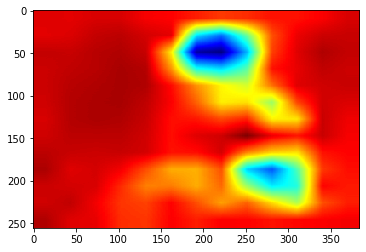

In [49]:
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)


h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread(img_dir)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5

plt.imshow(heatmap,cmap='hot', interpolation='nearest')

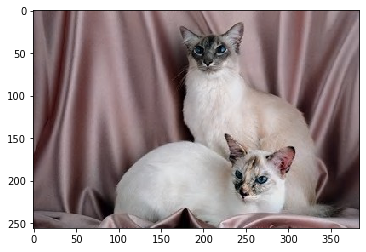

In [14]:
plt.imshow(Image.open(img_dir))

案外、前問のGuided BPやsmoothGradの方が明確なようにも感じる。final_convのみの編集で取り出せるのは優秀だとは思う。

### Grad-CAM
from https://github.com/jacobgil/pytorch-grad-cam

In [35]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layer, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu())

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu()] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []        
        return self.model(x)
    
class BaseCAM:
    def __init__(self, 
                 model, 
                 target_layer,
                 use_cuda=False,
                 reshape_transform=None):
        self.model = model.eval()
        self.target_layer = target_layer
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.activations_and_grads = ActivationsAndGradients(self.model, 
            target_layer, reshape_transform)

    def forward(self, input_img):
        return self.model(input_img)

    def get_cam_weights(self,
                        input_tensor,
                        target_category,
                        activations,
                        grads):
        raise Exception("Not Implemented")

    def get_loss(self, output, target_category):
        return output[:, target_category]

    def get_cam_image(self, input_tensor, target_category, activations, grads):
        weights = self.get_cam_weights(input_tensor, target_category, activations, grads)
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]
        return cam

    def __call__(self, input_tensor, target_category=None):
        if self.cuda:
            input_tensor = input_tensor.cuda()

        output = self.activations_and_grads(input_tensor)

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy())

        self.model.zero_grad()
        loss = self.get_loss(output, target_category)
        loss.backward(retain_graph=True)

        activations = self.activations_and_grads.activations[-1].cpu().data.numpy()[0, :]
        grads = self.activations_and_grads.gradients[-1].cpu().data.numpy()[0, :]
        cam = self.get_cam_image(input_tensor, target_category, activations, grads)

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_tensor.shape[2:][::-1])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam
    
class GradCAM(BaseCAM):
    def __init__(self, model, target_layer, use_cuda=False, 
        reshape_transform=None):
        super(GradCAM, self).__init__(model, target_layer, use_cuda, reshape_transform)

    def get_cam_weights(self, input_tensor, 
                              target_category, 
                              activations, grads):
        return np.mean(grads, axis=(1, 2))

####
def preprocess_image(img: np.ndarray, mean=None, std=None) -> torch.Tensor:
    if std is None:
        std = [0.5, 0.5, 0.5]
    if mean is None:
        mean = [0.5, 0.5, 0.5]

    preprocessing = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=mean, std=std)])

    return preprocessing(img.copy()).unsqueeze(0)

def show_cam_on_image(img: np.ndarray,
                  mask: np.ndarray,
                  use_rgb: bool = False,
                  colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception("The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [38]:
model = models.resnet50(pretrained=True)
target_layer = model.layer4[-1]

rgb_img = cv2.imread(img_dir, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# Create an input tensor image for your model..

print(input_tensor.shape)
# This should be constructed once:
cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)

# And then cam be used on many images:
grayscale_cam = cam(input_tensor=input_tensor)
visualization = show_cam_on_image(rgb_img, grayscale_cam)

torch.Size([1, 3, 224, 224])


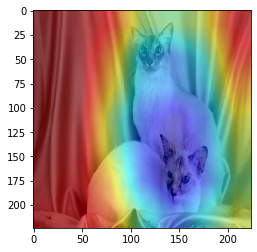

In [39]:
plt.imshow(visualization)

CAMの改良版なだけ、精度はよくなっているように思う。顔だけに反応するのではなく、被写体全体がうまく反応しているようで、実用性があるように思う。前問でのReLU書き換えなどもなく、特徴マップの時点で取り出せばいいようで、実装も楽そう？

参考<br>
https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py<br>
https://github.com/jacobgil/pytorch-grad-cam<br>